# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

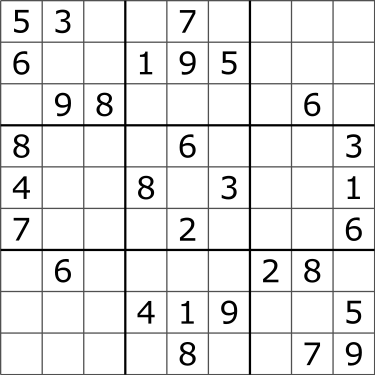

## Prepare environment

In [1]:
import sys
import os

project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# TODO: how to get rid of src (this is the only way VS Code resolves it)
from src.sudoku_solver.data.dataset import prepare_dataset
from src.sudoku_solver.data.preprocess import preprocess_input, preprocess_target
from src.sudoku_solver.model.model import prepare_model
from src.sudoku_solver.model.training import prepare_callbacks
from src.sudoku_solver.model.evaluation import plot_histories

import numpy as np
import tensorflow as tf
import keras

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
# 
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
# keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

2025-04-29 11:31:51.883852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745919111.919320   60888 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745919111.926299   60888 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 11:31:51.948165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [2]:
DATA_SIZE_LIMIT = 20_000

BATCH_SIZE = 256 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# Note: There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

USE_DISK_CACHE = False

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(BATCH_SIZE, size_limit=DATA_SIZE_LIMIT, use_disk_cache=USE_DISK_CACHE)

Trying to prepare dataset from disk
Serialized data folder ./sudoku_tfrecords/train_00 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_01 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_02 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_03 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_04 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_05 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_06 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_07 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_08 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_09 not found or empty.
Serialized data folder ./sudoku_tfrecords/val not found or empty.
Serialized data folder ./sudoku_tfrecords/test not found or empty.
Pre-processed sudoku data not found on disk. Downloading new version...
Path to dataset files: /home/martin/.cache/kaggle

I0000 00:00:1745919123.748354   60888 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Decoded CSV shape: (2, 9000000)
Download complete. Starting preprocess...
Original difficulty distribution: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   111   173   221   280   339   444   611
   756  1007  1270  1671  1974  2461  3000  3668  4413  5403  6409  7507
  9153 10443 12221 13887 15609 17374 18955 20391 21261 22226 21373 19659
 17314 14156 10509  6920  4064  1877   685   205]
Train difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.04 0.06 0.07 0.09 0.11 0.15 0.2  0.25 0.34 0.42 0.56
 0.66 0.82 1.   1.22 1.47 1.8  2.14 2.5  3.05 3.48 4.07 4.63 5.2  5.79
 6.32 6.8  7.09 7.41 7.12 6.55 5.77 4.72 3.5  2.31 1.35 0.63 0.23 0.07]
Val difficulty distribution (percentage): [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.04 0.07 0.08 0.09 0.11 0.15 0.2  0.25 0.33 0.41 0.56
 0.65 0.83 1.   1.23 1.47 1.8  2.13 2.49 

2025-04-29 11:36:42.317512: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_00 28500


2025-04-29 11:36:48.262972: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_01 28500
./sudoku_tfrecords/train_02 28500


2025-04-29 11:37:00.362644: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_03 28500
./sudoku_tfrecords/train_04 28500
./sudoku_tfrecords/train_05 28500
./sudoku_tfrecords/train_06 28500


2025-04-29 11:37:23.659545: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_07 28500
./sudoku_tfrecords/train_08 28500
./sudoku_tfrecords/train_09 28500
./sudoku_tfrecords/val 7500
./sudoku_tfrecords/test 7500
Dataset ready.


Measuring pipeline performance...:  11%|█         | 111/1000 [00:01<00:10, 83.20it/s]

Average batch fetch time is: 0.10880406697591145


In [4]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        # TODO: can't we reuse this conversion back to readable Sudoku puzzle? (e.g. invert operation)
        print(((X + 0.5) * 9).numpy().reshape((9, 9)).astype(int))
        print((y + 1).numpy().reshape((9, 9)))
        break

Validate dataset pipeline:

[[2 5 4 0 1 7 9 6 8]
 [0 0 9 8 5 4 0 1 3]
 [8 0 1 2 0 0 0 5 7]
 [4 2 6 9 3 8 1 7 5]
 [1 8 0 0 2 0 6 0 0]
 [5 9 3 0 7 6 8 2 4]
 [3 0 8 7 9 2 0 4 6]
 [7 0 5 6 8 1 0 9 0]
 [9 6 2 0 4 0 0 8 0]]
[[2 5 4 3 1 7 9 6 8]
 [6 7 9 8 5 4 2 1 3]
 [8 3 1 2 6 9 4 5 7]
 [4 2 6 9 3 8 1 7 5]
 [1 8 7 4 2 5 6 3 9]
 [5 9 3 1 7 6 8 2 4]
 [3 1 8 7 9 2 5 4 6]
 [7 4 5 6 8 1 3 9 2]
 [9 6 2 5 4 3 7 8 1]]


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

111

## Train model

### Prepare model

In [6]:
model = prepare_model(use_residual=USE_RESIDUAL, learning_rate=LEARNING_RATE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [7]:
histories = []
for train_dataset in train_datasets:
    training_callbacks = prepare_callbacks()

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    histories.append(history)

Epoch 1/3


I0000 00:00:1745919470.634124   60996 service.cc:148] XLA service 0x7f6c9c013340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745919470.634234   60996 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-29 11:37:50.812045: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745919471.654652   60996 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-04-29 11:37:52.825391: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[256,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_m

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1486 - loss: 2.7128

2025-04-29 11:38:20.348604: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 149ms/step - accuracy: 0.1489 - loss: 2.7096 - val_accuracy: 0.1105 - val_loss: 2.3281 - learning_rate: 0.0010
Epoch 2/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3081 - loss: 1.8833

2025-04-29 11:38:34.909087: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.3086 - loss: 1.8820 - val_accuracy: 0.1242 - val_loss: 2.9054 - learning_rate: 0.0010
Epoch 3/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6208 - loss: 1.1503

2025-04-29 11:38:49.323841: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.6214 - loss: 1.1490 - val_accuracy: 0.1660 - val_loss: 4.4769 - learning_rate: 0.0010
Epoch 1/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2630 - loss: 1.9903

2025-04-29 11:39:05.893796: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.2635 - loss: 1.9891 - val_accuracy: 0.1078 - val_loss: 2.7155 - learning_rate: 0.0010
Epoch 2/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5587 - loss: 1.3042

2025-04-29 11:39:20.391391: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5593 - loss: 1.3028 - val_accuracy: 0.1729 - val_loss: 4.0584 - learning_rate: 0.0010
Epoch 3/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7982 - loss: 0.7129 - val_accuracy: 0.2176 - val_loss: 3.7588 - learning_rate: 0.0010
Epoch 1/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.5062 - loss: 1.4289 - val_accuracy: 0.1787 - val_loss: 4.0991 - learning_rate: 0.0010
Epoch 2/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.7702 - loss: 0.7825 - val_accuracy: 0.2171 - val_loss: 3.7877 - learning_rate: 0.0010
Epoch 3/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.8365 - loss: 0.5967 - val_accuracy: 0.3901 - val_loss: 2.4776 - learning_rate: 0.0010
Epoch 1/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.7836 - loss: 0.7167 - val_accuracy: 0.7698 - val_loss: 0.7388 - learning_rate: 0.0010
Epoch 2/3
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.8353 - loss: 0.587

### Save model

In [8]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

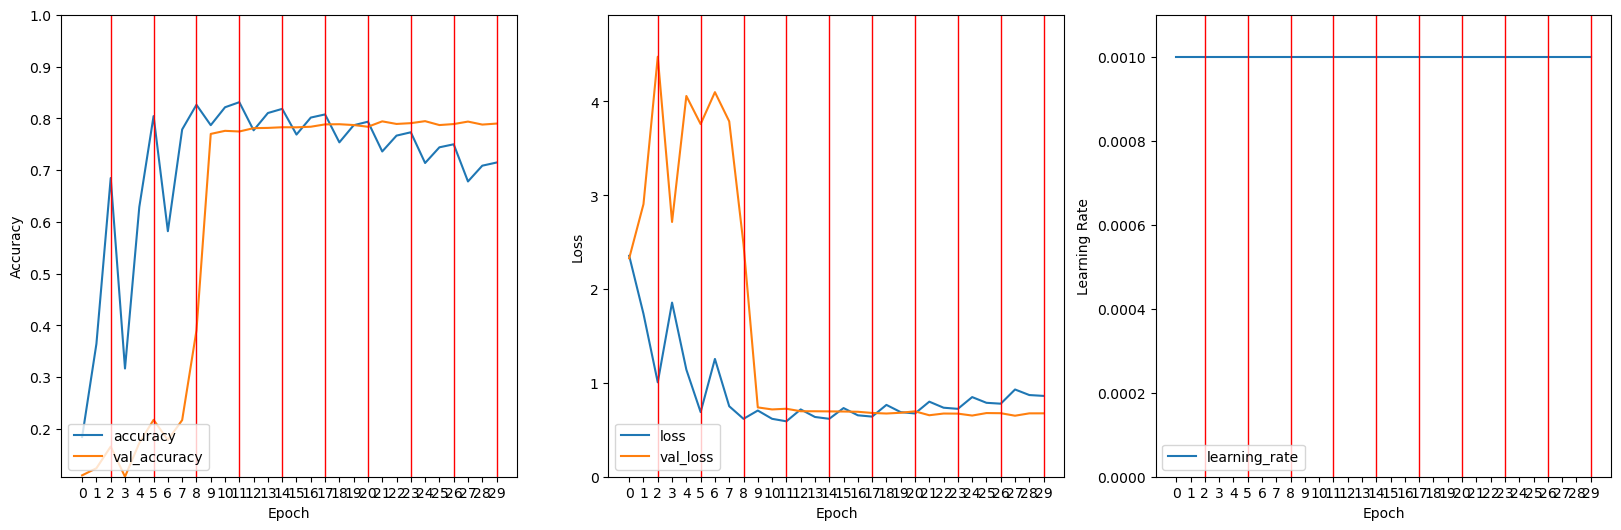

In [9]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [10]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [11]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [12]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [13]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [14]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

2025-04-29 11:45:48.078890: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-29 11:45:48.714594: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[9,16,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,128,5,5]{3,2,1,0}, f32[16,128,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[8 6 3 2 5 9 7 1 4]
 [4 2 5 1 6 7 9 3 8]
 [7 7 1 4 3 8 2 6 5]
 [6 9 2 8 4 5 3 7 7]
 [9 5 4 6 7 3 1 5 8]
 [3 3 7 9 1 2 5 4 2]
 [5 4 8 7 9 9 6 3 3]
 [7 7 6 5 2 1 4 8 9]
 [2 7 9 5 8 6 5 7 1]]


In [15]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1745919950.615094   60992 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8025 - loss: 0.7432


In [16]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[4 2 8 5 1 9 6 3 7]
 [1 5 6 3 4 7 8 2 9]
 [3 7 7 6 2 6 5 4 1]
 [8 3 5 9 6 1 2 7 4]
 [6 8 9 4 8 3 9 1 5]
 [9 1 4 7 5 2 3 6 8]
 [8 6 2 2 7 5 4 9 3]
 [9 5 1 2 4 3 7 8 6]
 [7 4 3 6 9 8 1 5 2]]


In [17]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8395 - loss: 0.5785


0.8395061492919922

### Evaluate on different difficulties

In [18]:
for index, train_dataset in enumerate(train_datasets):
    loss, accuracy = model.evaluate(train_dataset, verbose=0)
    print(f"Difficulty {index + 1}: loss={loss}, accuracy={accuracy}")
    
    for X_batch, _ in train_dataset.take(1):
        avg_non_zero_count = tf.reduce_mean(tf.math.count_nonzero((X_batch + 0.5) * 9, axis=(1, 2)))
        print(f"Average non-zero numbers in puzzle in one batch: {int(avg_non_zero_count)}\n")


Difficulty 1: loss=0.34984874725341797, accuracy=0.9227547645568848
Average non-zero numbers in puzzle in one batch: 51



2025-04-29 11:45:56.265041: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Difficulty 2: loss=0.46859920024871826, accuracy=0.8724943995475769
Average non-zero numbers in puzzle in one batch: 45

Difficulty 3: loss=0.5382500290870667, accuracy=0.8427371382713318
Average non-zero numbers in puzzle in one batch: 42

Difficulty 4: loss=0.5919092297554016, accuracy=0.8193865418434143
Average non-zero numbers in puzzle in one batch: 40

Difficulty 5: loss=0.6414392590522766, accuracy=0.797989010810852
Average non-zero numbers in puzzle in one batch: 38

Difficulty 6: loss=0.6756651997566223, accuracy=0.7830134034156799
Average non-zero numbers in puzzle in one batch: 37

Difficulty 7: loss=0.7212365865707397, accuracy=0.7634384632110596
Average non-zero numbers in puzzle in one batch: 35

Difficulty 8: loss=0.7651775479316711, accuracy=0.7445569634437561
Average non-zero numbers in puzzle in one batch: 34

Difficulty 9: loss=0.8047977685928345, accuracy=0.7275781631469727
Average non-zero numbers in puzzle in one batch: 32

Difficulty 10: loss=0.7534526586532593, 

### Evaluate test set performance

In [19]:
loss, accuracy = model.evaluate(test_dataset)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7925 - loss: 0.6531


In [20]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.7934892177581787 and loss: 0.6512795090675354


The End